First:
- go to the terminal
- go to the `4_tuning_networks` folder, use `cd` to get there, or `z` to get there faster.
- if you are planning on closing the laptop to let this run by itself, start a tmux session by giving the command `tmux`. You can name the session with `ctrl+b $`, leave the tmux with `ctrl+b` d, access it again with `tmux a -t 0` or replace the 0 with the name you gave it. See [tmux](https://github.com/tmux/tmux/wiki/Getting-Started) for more info.
- Activate the `.venv`, and run `python hypertune.py`
- In the hypertune.py file, a tune_dir is specified: `models/ray`. We will check the contents of that folder after the hypertune finished. You can also use tensorboard to check the results. 
- this will take some time. I clocked 1901 seconds (30 minutes) on the VM

 0.0992908 |           119 |            3 |     26 |         576.744  |    0 |   0.942187

In [1]:
from pathlib import Path
tune_dir = Path("models/ray").resolve()
tune_dir.exists()

True

In [2]:
tunelogs = [d for d in tune_dir.iterdir()]
tunelogs.sort()
latest = tunelogs[-1]
latest

PosixPath('/Users/francesca/code_repo/MADS-exam-25/src/models/ray/train_2025-02-02_13-04-11')

In [3]:
from ray.tune import ExperimentAnalysis
import ray
ray.init(ignore_reinit_error=True)


analysis = ExperimentAnalysis(latest)


2025-02-02 17:08:50,336	INFO worker.py:1821 -- Started a local Ray instance.


So, we find some info:

In [4]:
analysis.results_df.columns


Index(['iterations', 'train_loss', 'test_loss', 'Accuracy', 'F1scoremicro',
       'F1scoremacro', 'Precisionmacro', 'Recallmacro', 'timestamp',
       'checkpoint_dir_name', 'done', 'training_iteration', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'experiment_tag',
       'config/preprocessor', 'config/optimizer', 'config/tune_dir',
       'config/data_dir', 'config/seed', 'config/gru_hidden', 'config/input',
       'config/batch', 'config/hidden', 'config/dropout', 'config/num_layers',
       'config/model_type', 'config/num_heads', 'config/num_blocks',
       'config/num_classes', 'config/scheduler', 'config/factor',
       'config/patience', 'config/earlystopping_patience',
       'config/input_length', 'config/traindataset', 'config/trainfile',
       'config/testfile'],
      dtype='object')

Let's focus on the parameters we wanted to tune.

In [5]:
import plotly.express as px

plot = analysis.results_df
select = ["Accuracy", "config/hidden", "config/dropout", "config/batch"]
p = plot[select].reset_index().dropna()


Let's sort by accuracy

In [6]:
p.sort_values("Accuracy", inplace=True)

Make a parallel plot

In [7]:
px.parallel_coordinates(p, color="Accuracy")


<Axes: xlabel='config/hidden', ylabel='config/batch'>

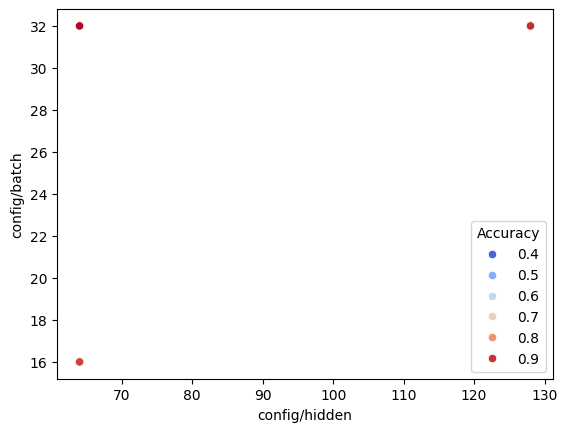

In [21]:
import seaborn as sns

sns.scatterplot(data=p, x="config/hidden", y="config/batch", hue="Accuracy", palette="coolwarm")

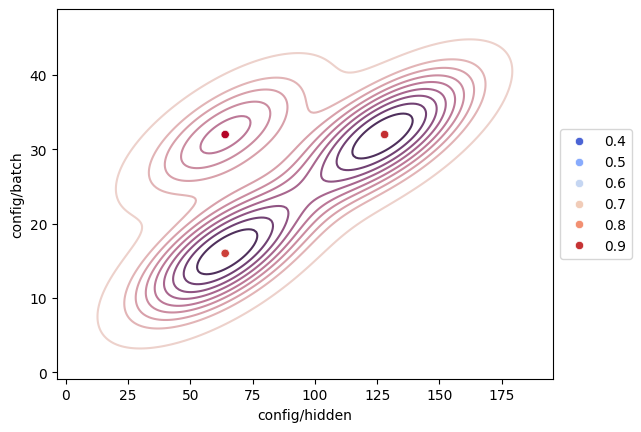

In [23]:
import matplotlib.pyplot as plt
cmap = sns.cubehelix_palette(as_cmap=True)
sns.scatterplot(data=p, x="config/hidden", y="config/batch", hue="Accuracy", palette="coolwarm")
sns.kdeplot(data=p, x="config/hidden", y="config/batch", cmap=cmap)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

Get the best trial

In [14]:
analysis.get_best_trial(metric="test_loss", mode="min")


train_fc263c4d

The top ten

In [15]:
p[-10:]


,trial_id,Accuracy,config/hidden,config/dropout,config/num_layers
10,2c700a82,0.368107,128.0,0.3,4.0
6,5e49ec56,0.825827,128.0,0.2,3.0
8,7a322dbd,0.845696,64.0,0.3,3.0
11,d1bddff1,0.860806,64.0,0.4,4.0
9,c58e101a,0.880055,128.0,0.3,4.0
3,1deb50cb,0.887134,64.0,0.3,2.0
14,4c7380ea,0.888278,64.0,0.3,2.0
2,dab05494,0.904642,128.0,0.2,3.0
5,9bd993dc,0.909007,64.0,0.2,2.0
0,fc263c4d,0.926930,64.0,0.4,2.0


Or the best config

In [16]:
analysis.get_best_config(metric="Accuracy", mode="max")


{'preprocessor': mltrainer.preprocessors.BasePreprocessor,
 'optimizer': torch.optim.adam.Adam,
 'tune_dir': PosixPath('/Users/francesca/code_repo/MADS-exam-25/src/models/ray'),
 'data_dir': PosixPath('/Users/francesca/code_repo/MADS-exam-25/data/processed'),
 'seed': 1691705107,
 'gru_hidden': 256,
 'input': 1,
 'batch': 32,
 'hidden': 64,
 'dropout': 0.4,
 'num_layers': 2,
 'model_type': 'CNN1DGRUResNet',
 'num_blocks': 5,
 'num_classes': 5,
 'num_heads': 2,
 'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau,
 'factor': 0.2,
 'patience': 2,
 'earlystopping_patience': 15,
 'input_length': 192,
 'traindataset': 'smote',
 'trainfile': PosixPath('/Users/francesca/code_repo/MADS-exam-25/data/processed/heart_big_oversampled_full_train.parq'),
 'testfile': PosixPath('/Users/francesca/code_repo/MADS-exam-25/data/processed/heart_big_test.parq')}

In [23]:
import pandas as pd
from ray.tune import ExperimentAnalysis
from loguru import logger
from pathlib import Path
import ray


def load_tunelogs_data(path="models/ray") -> pd.DataFrame:
        """
        Loads the Ray Tune results from a specified directory and returns them as a DataFrame.

        Args:
            path (str): Directory path containing Ray Tune experiment logs.

        Returns:
            pd.DataFrame: Combined and cleaned results DataFrame.
        """
        tune_dir = Path(path).resolve()
        logger.info(f"Tune directory: {tune_dir}")
        if not tune_dir.exists():
            logger.warning("Model data directory does not exist. Check your tune directory path.")
            return pd.DataFrame()

        # Initialize Ray
        ray.init(ignore_reinit_error=True)

        # Collect all directories within the tune_dir
        tunelogs = sorted([d for d in tune_dir.iterdir() if d.is_dir()])
        results = []

        for logs in tunelogs:
            try:
                # Load experiment analysis
                analysis = ExperimentAnalysis(logs)

                # Convert results to DataFrame
                df = analysis.dataframe()
                df.columns = [col.lower().replace("config/", "") for col in df.columns]
                df.sort_values("accuracy", inplace=True, ascending=False)

                # Add experiment name as a column
                df["experiment"] = logs.name.replace("train_", "")

                # Optionally get best trial (for debugging/logging purposes)
                best_trial = analysis.get_best_trial(metric="test_loss", mode="min")
                if best_trial:
                    logger.info(f"Best trial for {logs.name}: {best_trial}")

                # Accumulate DataFrame
                results.append(df)

            except Exception as e:
                logger.error(f"Failed to process {logs}: {e}")

        # Combine all results into a single DataFrame
        results_df = pd.concat(results, ignore_index=True)

        # Get the top 10 rows based on accuracy
        if "recallmacro" in results_df.columns:
            print(results_df.columns)
            top_10_df = results_df.nlargest(20, "recallmacro")
            top_10_df['trainfile'] = top_10_df['trainfile'].apply(lambda x: x.name)
            top_10_df = top_10_df[["experiment", "trial_id", "accuracy", "model_type", "test_loss", "batch", 'optimizer', 'num_blocks', "dropout", "hidden", "num_layers", "num_heads", "recallmacro", "iterations", "factor", "trainfile"]]
            top_10_df.reset_index(drop=True, inplace=True)
            print(top_10_df)
            # Save the top 10 results to a CSV file
            top_10_df.to_csv("top10_results.csv", index=False)
            top_10_df.reset_index(drop=True, inplace=True)
            top_config = top_10_df.iloc[0].to_dict()
            print(f"Top model configurations:{top_config}")
            
        return top_10_df, results_df

top_10_df, results_df=load_tunelogs_data()
print(top_config)

2025-02-02 17:29:12.995 | INFO     | __main__:load_tunelogs_data:19 - Tune directory: /Users/francesca/code_repo/MADS-exam-25/src/models/ray
2025-02-02 17:29:13,010	INFO worker.py:1654 -- Calling ray.init() again after it has already been called.
2025-02-02 17:29:13.031 | INFO     | __main__:load_tunelogs_data:47 - Best trial for train_2025-01-21_20-12-30: train_85395c8b
2025-02-02 17:29:13.051 | INFO     | __main__:load_tunelogs_data:47 - Best trial for train_2025-01-22_00-11-48: train_35901bdf
2025-02-02 17:29:13.074 | INFO     | __main__:load_tunelogs_data:47 - Best trial for train_2025-01-22_09-31-05: train_b9a3cf06
2025-02-02 17:29:13.097 | INFO     | __main__:load_tunelogs_data:47 - Best trial for train_2025-01-22_11-32-38: train_8acc2e65
2025-02-02 17:29:13.118 | INFO     | __main__:load_tunelogs_data:47 - Best trial for train_2025-01-22_12-48-20: train_102d91aa
2025-02-02 17:29:13.140 | INFO     | __main__:load_tunelogs_data:47 - Best trial for train_2025-01-22_14-19-25: train_

Index(['iterations', 'train_loss', 'test_loss', 'accuracy', 'f1scoremicro',
       'f1scoremacro', 'precisionmacro', 'recallmacro', 'timestamp',
       'checkpoint_dir_name', 'done', 'training_iteration', 'trial_id', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'preprocessor',
       'trainfile', 'testfile', 'tune_dir', 'data_dir', 'batch', 'hidden',
       'dropout', 'num_layers', 'model_type', 'num_blocks', 'num_classes',
       'shape', 'logdir', 'experiment', 'num_heads', 'scheduler', 'factor',
       'patience', 'input', 'optimizer', 'earlystopping_patience',
       'input_length', 'gru_hidden', 'seed', 'traindataset'],
      dtype='object')
             experiment  trial_id  accuracy                model_type  \
0   2025-02-01_18-39-26  d77553d2  0.984890            CNN1DGRUResNet   
1   2025-01-25_10-39-41  b8ba2056  0.988782               2DCNNResnet   
2   2025-01-25_15-38-08  1044f763

In [52]:
cnngru_df = results_df[results_df["model_type"] == "CNN1DGRUResNet"]
cnngru_df.sort_values("accuracy", inplace=True, ascending=False)

/var/folders/n8/nxkbkrzj5b7brdryft6ds0kc0000gn/T/ipykernel_65159/122469855.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [36]:
cnngru_df.columns

Index(['iterations', 'train_loss', 'test_loss', 'accuracy', 'f1scoremicro',
       'f1scoremacro', 'precisionmacro', 'recallmacro', 'timestamp',
       'checkpoint_dir_name', 'done', 'training_iteration', 'trial_id', 'date',
       'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip',
       'time_since_restore', 'iterations_since_restore', 'preprocessor',
       'trainfile', 'testfile', 'tune_dir', 'data_dir', 'batch', 'hidden',
       'dropout', 'num_layers', 'model_type', 'num_blocks', 'num_classes',
       'shape', 'logdir', 'experiment', 'num_heads', 'scheduler', 'factor',
       'patience', 'input', 'optimizer', 'earlystopping_patience',
       'input_length', 'gru_hidden', 'seed', 'traindataset'],
      dtype='object')

In [71]:
plot = cnngru_df[:10]
select = ['traindataset', "num_blocks",  "dropout", "hidden", "num_layers",  "test_loss"]
p = plot[select].reset_index().dropna()
p.drop(columns=["index"], inplace=True)

In [72]:
p

,traindataset,num_blocks,dropout,hidden,num_layers,test_loss
0,smote,5,0.4,64,2,0.091874
1,smote,4,0.2,64,4,0.086679
3,smote,5,0.2,64,3,0.109999
5,smote,2,0.2,64,2,0.107881
6,oversampled,3,0.2,128,3,0.118306
7,smote,5,0.4,128,3,0.124042
8,smote,4,0.3,64,2,0.112295
9,oversampled,2,0.3,64,3,0.119339


In [74]:
px.parallel_coordinates(p, color="test_loss")

In [33]:
results_df[results_df["model_type"] == "CNN1DGRUResNet"].sort_values("accuracy", ascending=False)

,iterations,train_loss,test_loss,accuracy,f1scoremicro,f1scoremacro,precisionmacro,recallmacro,timestamp,checkpoint_dir_name,...,scheduler,factor,patience,input,optimizer,earlystopping_patience,input_length,gru_hidden,seed,traindataset
697,27,0.008405,0.091874,0.985754,0.985754,0.935855,0.957192,0.959340,1738405496,None,...,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,0.2,2.0,1.0,<class 'torch.optim.adam.Adam'>,15.0,192.0,256.0,1.691705e+09,smote
727,25,0.009938,0.086679,0.984890,0.984890,0.945104,0.955737,0.976865,1738435792,None,...,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,0.3,2.0,1.0,<class 'torch.optim.adam.Adam'>,10.0,192.0,256.0,1.387545e+09,smote
637,36,0.009846,0.078768,0.984605,0.984605,0.923509,0.943774,0.957577,1738353509,None,...,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,0.3,2.0,1.0,<class 'torch.optim.adam.Adam'>,15.0,192.0,256.0,1.423657e+09,NaN
742,38,0.006330,0.109999,0.984605,0.984605,0.923855,0.961065,0.943402,1738440029,None,...,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,0.4,2.0,1.0,<class 'torch.optim.adam.Adam'>,10.0,192.0,64.0,2.950020e+09,smote
638,35,0.005719,0.103465,0.982537,0.982537,0.928862,0.945878,0.963731,1738352611,None,...,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,0.4,2.0,1.0,<class 'torch.optim.adam.Adam'>,15.0,192.0,256.0,1.423657e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,0,1.096165,1.410183,0.214973,0.214973,0.185480,0.299599,0.448787,1738431865,None,...,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,0.3,2.0,1.0,<class 'torch.optim.adam.Adam'>,10.0,192.0,32.0,1.387545e+09,oversampled
741,0,0.945043,1.383928,0.201007,0.201007,0.221119,0.315438,0.513606,1738431794,None,...,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,0.3,2.0,1.0,<class 'torch.optim.adam.Adam'>,10.0,192.0,32.0,1.387545e+09,smote
456,0,1.434307,1.413909,0.187271,0.187271,0.160745,0.257648,0.389228,1738239225,None,...,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,0.4,2.0,1.0,<class 'torch.optim.adam.Adam'>,15.0,192.0,32.0,1.738238e+09,NaN
756,0,1.033554,1.379333,0.186581,0.186581,0.219728,0.316293,0.574078,1738436790,None,...,<class 'torch.optim.lr_scheduler.ReduceLROnPla...,0.2,2.0,1.0,<class 'torch.optim.adam.Adam'>,10.0,192.0,32.0,2.950020e+09,oversampled


In [24]:
top_10_df

,experiment,trial_id,accuracy,model_type,test_loss,batch,optimizer,num_blocks,dropout,hidden,num_layers,num_heads,recallmacro,iterations,factor,trainfile
0,2025-02-01_18-39-26,d77553d2,0.984890,CNN1DGRUResNet,0.086679,16,<class 'torch.optim.adam.Adam'>,4,0.200000,64,4,NaN,0.976865,25,0.300000,heart_big_oversampled_full_train.parq
1,2025-01-25_10-39-41,b8ba2056,0.988782,2DCNNResnet,0.066563,16,NaN,1,0.300000,128,3,8.0,0.974396,29,0.200000,heart_big_oversampled_full_train.parq
2,2025-01-25_15-38-08,1044f763,0.987866,2DCNNResnet,0.090779,16,NaN,3,0.300000,64,3,8.0,0.973342,39,0.300000,heart_big_oversampled_full_train.parq
3,2025-01-23_20-23-12,f068537b,0.987866,2DCNNResnet,0.112456,16,NaN,3,0.338071,128,4,4.0,0.967824,39,0.200000,heart_big_oversampled_full_train.parq
4,2025-01-25_15-38-08,a8e7b5d8,0.980082,2DCNNResnet,0.091605,16,NaN,3,0.300000,128,2,8.0,0.967541,8,0.300000,heart_big_oversampled_full_train.parq
5,2025-01-25_15-38-08,23916882,0.986722,2DCNNResnet,0.118468,16,NaN,1,0.300000,64,2,8.0,0.964716,39,0.300000,heart_big_oversampled_full_train.parq
6,2025-01-31_18-57-36,6adccf0a,0.982537,CNN1DGRUResNet,0.103465,32,<class 'torch.optim.adam.Adam'>,3,0.300000,128,2,4.0,0.963731,35,0.400000,heart_big_SMOTE_train.parq
7,2025-02-01_22-28-09,912a8b41,0.975184,CNN2DResNet,0.088695,32,<class 'torch.optim.adam.Adam'>,7,0.300000,64,2,8.0,0.963705,8,0.400000,heart_big_oversampled_full_train.parq
8,2025-01-25_10-39-41,5bbd8621,0.983288,2DCNNResnet,0.128833,16,NaN,2,0.300000,64,2,8.0,0.962754,26,0.200000,heart_big_oversampled_full_train.parq
9,2025-01-23_15-55-17,a2a725a8,0.962683,2DTransformerResnet,0.123315,16,NaN,2,0.274700,64,3,8.0,0.961623,29,0.274803,heart_big_oversampled_full_train.parq
